# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In [1]:
import datetime
import numpy as np
import pickle
import skimage
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import csv
import cv2
import random
import time
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

---
## Step 0: Load The Data

In [2]:
signnames = {}
with open('signnames.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        try:
            signnames[int(row[0])] = row[1]
        except ValueError:
            pass

In [3]:
# Load data
training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [4]:
# Number of train/validation/test examples
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:4]
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
def show_sample(X_train, y_train, signnames):
    # Show picture of each sign class (small though so can fit all of them in one image) labelled, with bounding boxes drawn on
    fig, axes = plt.subplots(11, 4, figsize=(12, 32), subplot_kw={'xticks': [], 'yticks': []})
    # fig.subplots_adjust(hspace=0.5)
    for ax, _class in zip(axes.flat, set(y_train)):

        correct_class = [x for x, y in zip(X_train, y_train) if y == _class]
        ax.imshow(random.choice(correct_class).squeeze(), cmap='gray')

        if len(signnames[_class]) > 20:
            ax.set_title(signnames[_class][:20] + '...')
        else:
            ax.set_title(signnames[_class])

    plt.show()
    return fig, axes
    

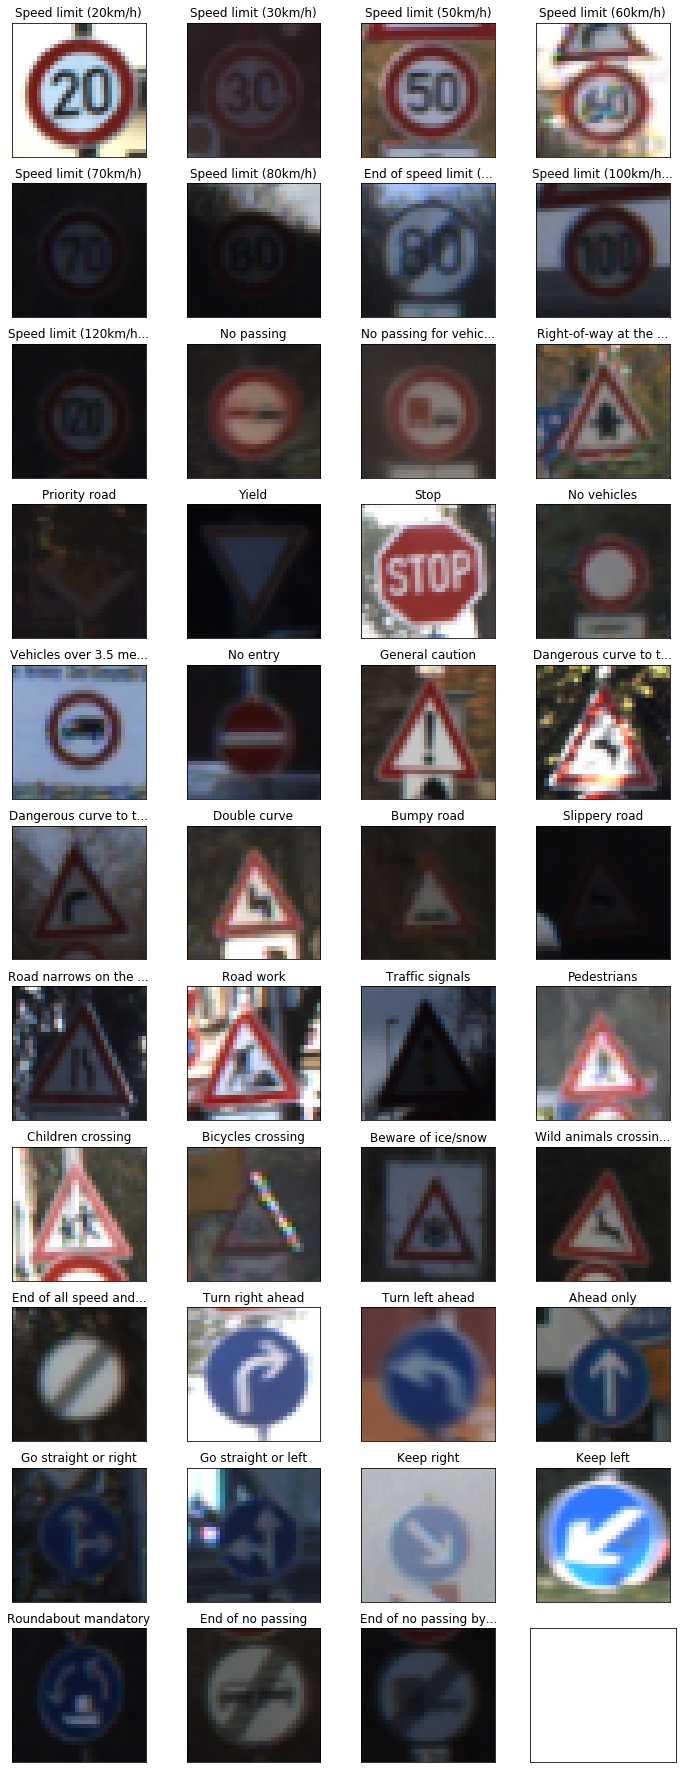

In [6]:
fig, axes = show_sample(X_train, y_train, signnames)
fig.savefig('./Writeup/all_signs.jpg', bbox_inches='tight')

In [7]:
def visualize_distribution(labels, counts):
    fig, ax = plt.subplots()
    plt.bar(range(len(counts)), counts)
    plt.xticks(range(len(counts)), labels, rotation='vertical')
    plt.margins(0.02)
    plt.subplots_adjust(bottom=0.15)
    plt.tick_params(axis='x', which='major', labelsize=7)
    ax.set_xlabel('Sign types', fontsize=18)
    ax.set_ylabel('Count', fontsize=16)
    plt.show()
    return fig, ax

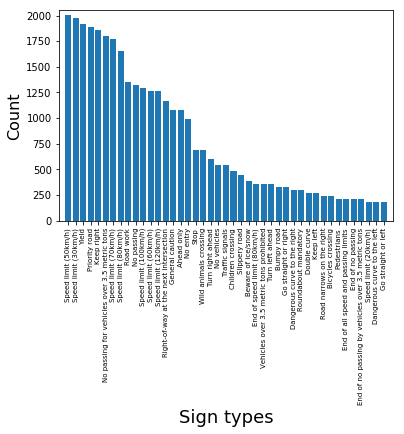

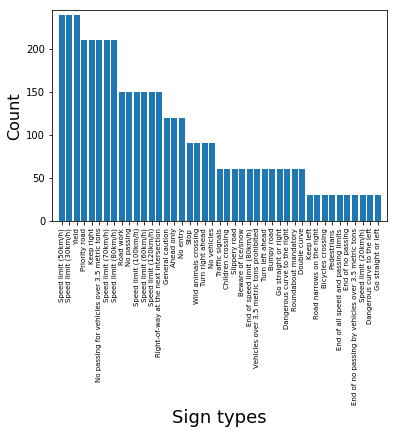

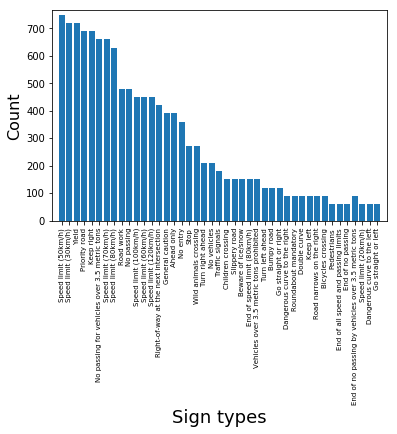

In [8]:
from collections import Counter

sign_count = Counter(y_train)
counts_sorted = sign_count.most_common()
counts = [x[1] for x in counts_sorted]
labels = [signnames[x[0]] for x in counts_sorted]
# print(list(zip(labels, counts)))

fig, ax = visualize_distribution(labels, counts)
fig.savefig('./Writeup/train_distribution.jpg', bbox_inches='tight')

sign_count = Counter(y_valid)
counts = [sign_count[x[0]] for x in counts_sorted]
fig, ax = visualize_distribution(labels, counts)
fig.savefig('./Writeup/valid_distribution.jpg', bbox_inches='tight')

sign_count = Counter(y_test)
counts = [sign_count[x[0]] for x in counts_sorted]
fig, ax = visualize_distribution(labels, counts)
fig.savefig('./Writeup/test_distribution.jpg', bbox_inches='tight')

----

## Step 2: Model Architecture

### Pre-process the Data Set

In [9]:
# Generate fake data from the original image.

# Translate
def translate_image(img, shift_x, shift_y):
    rows, cols, c = img.shape
    M = np.float32([[1,0,shift_x],[0,1,shift_y]])
    return cv2.warpAffine(img,M,(cols,rows))

# Rotate
def rotate_image(img, angle):
    rows, cols, c = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    return cv2.warpAffine(img,M,(cols,rows))

# Scale (actually zoom as want to keep original array size)
def zoom_image(img, zoom_factor):
    """
    Zoom the image and return a copy of the image at the new zoom level.
    Zoom is centred.
    If zooming out (e.g. zoom_factor < 1) then padded with zeroes.
    
    Params:
        img: image data (3d numpy array)
        zoom_factor: float, if > 1 then zoom in, else zoom out.

    Returns:
        image
    """
    w, h, c = img.shape
    zoomed = cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor)
    zoomed = zoomed
    w2, h2, c2 = zoomed.shape
    centre = (int(w / 2), int(h / 2))

    x_diff = abs(int(round((w2 - w) / 2)))
    y_diff = abs(int(round((h2 - h) / 2)))

    if zoom_factor >=1:
        return zoomed[x_diff:w+x_diff, y_diff:h+y_diff, :]
    else:
        out = np.zeros_like(img)
        out[x_diff: x_diff + w2, y_diff:y_diff + h2, :] = zoomed
        return out

# TODO: Skew
def skew_image(img):
    pass

In [10]:
def generate_fakes(img, count):
    """
    For each image, generate multiple 'fake' images with
    small, random translations/rotations/zooming
    """
    new_imgs = []
    for i in range(count):
        max_shift = int(img.shape[0]/8)
        shift_x = random.randrange(-max_shift, max_shift)
        shift_y = random.randrange(-max_shift, max_shift)
        angle = random.uniform(-10, 10)
        zoom = random.uniform(0.9, 1.1)
#         print('ShiftXY/angle/zoom', shift_x, shift_y, angle, zoom)

        new_img = translate_image(img, shift_x, shift_y)
        new_img = rotate_image(new_img, angle)
        new_img = zoom_image(new_img, zoom)
        new_imgs.append(new_img)
    return new_imgs

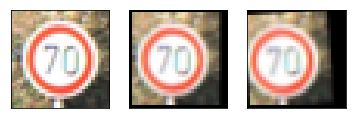

In [11]:
img = X_train[8000]
fakes = generate_fakes(img, 2)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(img)
axes[1].imshow(fakes[0])
axes[2].imshow(fakes[1])
for ax in axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# fig.savefig('./Writeup/augmentation_examples.jpg', bbox_inches='tight')

In [12]:
FAKE_COUNT = 2

if FAKE_COUNT:

    X_train_generated = np.asarray([generate_fakes(img, FAKE_COUNT) for img in X_train])
    y_train_generated = np.asarray([[label]*FAKE_COUNT for label in y_train])
    assert X_train_generated.shape[0] == y_train_generated.shape[0]

    X_train_generated = np.reshape(X_train_generated, [-1] + list(X_train.shape[1:]))
    y_train_generated = np.reshape(y_train_generated, [-1] + list(y_train.shape[1:]))
    assert X_train_generated.shape[0] == y_train_generated.shape[0]

    # Add the fake images and labels to X_train, y_train
    X_train = np.vstack((X_train, X_train_generated))
    y_train = np.concatenate((y_train, y_train_generated))
    assert X_train.shape[0] == y_train.shape[0]

In [13]:
# Grayscale
def rgb2gray(img):
    # Vectorized grayscale
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

if True:
    # Note - RGB is correct (not BGR) as we're not using cv2.imread()
    X_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_train])
    X_valid_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_valid])
    X_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_test])

    X_train_gray = X_train_gray[:,:,:,None]
    X_valid_gray = X_valid_gray[:,:,:,None]
    X_test_gray = X_test_gray[:,:,:,None]
    
    print(X_train.shape)
    print(X_train_gray.shape)
    X_train = np.concatenate((X_train, X_train_gray), axis=3)
    X_valid = np.concatenate((X_valid, X_valid_gray), axis=3)
    X_test = np.concatenate((X_test, X_test_gray), axis=3)
    print(X_train.shape)

(104397, 32, 32, 3)
(104397, 32, 32, 1)
(104397, 32, 32, 4)


(array([  154.,  1063.,   788.,   309.,   130.,   129.,   127.,   118.,
          100.,   132.,   105.,    86.,    60.,    60.,    76.,    79.,
           64.,   110.,    90.,    63.,    55.,    90.,    81.,    25.,
            2.]),
 array([  19.  ,   22.76,   26.52,   30.28,   34.04,   37.8 ,   41.56,
          45.32,   49.08,   52.84,   56.6 ,   60.36,   64.12,   67.88,
          71.64,   75.4 ,   79.16,   82.92,   86.68,   90.44,   94.2 ,
          97.96,  101.72,  105.48,  109.24,  113.  ]),
 <a list of 25 Patch objects>)

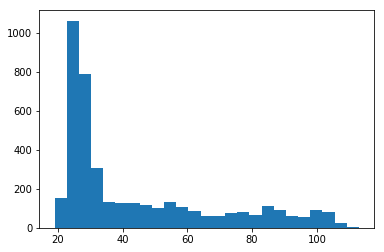

In [14]:
plt.hist(X_train[0].flatten(), bins=25)

In [15]:
# Should normalise for brightness using cv2 histEqualize
def equalizeHist(imgs):
    # NOTE - this error "_src.type() == CV_8UC1 in function equalizeHist" means
    # something wrong with datatype coming in, if INT it expects range 0-255,
    # if float it expects 0.0-1.0
    for img in imgs:
        img[:,:,0] = cv2.equalizeHist(img[:,:,0])
        img[:,:,1] = cv2.equalizeHist(img[:,:,1])
        img[:,:,2] = cv2.equalizeHist(img[:,:,2])
        img[:,:,3] = cv2.equalizeHist(img[:,:,3])

In [16]:
if True:
    equalizeHist(X_train)
    equalizeHist(X_valid)
    equalizeHist(X_test)

(array([ 132.,   86.,  144.,  176.,   99.,    0.,  323.,  157.,  174.,
         120.,  273.,  225.,  214.,  145.,  181.,  178.,  149.,  156.,
         173.,  160.,  172.,  169.,  145.,  164.,  181.]),
 array([   0. ,   10.2,   20.4,   30.6,   40.8,   51. ,   61.2,   71.4,
          81.6,   91.8,  102. ,  112.2,  122.4,  132.6,  142.8,  153. ,
         163.2,  173.4,  183.6,  193.8,  204. ,  214.2,  224.4,  234.6,
         244.8,  255. ]),
 <a list of 25 Patch objects>)

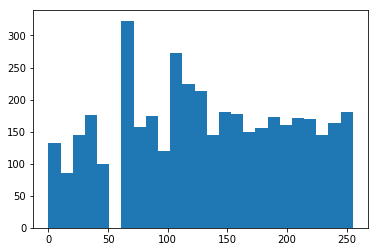

In [17]:
plt.hist(X_train[0].flatten(), bins=25)

In [18]:
# NORMALIZE
X_train_normalised = X_train / 255. - 0.5
X_valid_normalised = X_valid / 255. - 0.5
X_test_normalised = X_test / 255. - 0.5
assert np.max(X_train_normalised) <= 0.5
assert np.min(X_train_normalised) >= -0.5

### Model Architecture

In [19]:
def conv2d(x, W, b, strides=1, padding='SAME'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def fully_connected(x, W, b):
    x = tf.add(tf.matmul(x, W), b)
    return tf.nn.relu(x)

def LeNet(x):
    mu = 0
    sigma = 0.1

    weights = {
        'layer1': tf.Variable(tf.truncated_normal(shape=(5, 5, 4, 6), mean = mu, stddev = sigma)),
        'layer2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
        'layer3': tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma)),
        'layer4': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)),
        'layer5': tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    }

    biases = {
        'layer1': tf.Variable(tf.zeros(6)),
        'layer2': tf.Variable(tf.zeros(16)),
        'layer3': tf.Variable(tf.zeros(120)),
        'layer4': tf.Variable(tf.zeros(84)),
        'layer5': tf.Variable(tf.zeros(n_classes))
    }

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['layer1'], biases['layer1'], 1, 'VALID')
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    mp1 = tf.nn.max_pool(
        conv1,
        ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(mp1, weights['layer2'], biases['layer2'], 1, 'VALID')

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    mp2 = tf.nn.max_pool(
        conv2,
        ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(mp2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc3 = fully_connected(flat, weights['layer3'], biases['layer3'])
    
    # Dropout
    drp3 = tf.nn.dropout(fc3, prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc4 = fully_connected(drp3, weights['layer4'], biases['layer4'])
    
    # Dropout
    drp4 = tf.nn.dropout(fc4, prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.matmul(drp4, weights['layer5']) + biases['layer5']

    return logits

In [20]:
learning_rate = 0.0002
EPOCHS = 100
BATCH_SIZE = 128

In [21]:
x = tf.placeholder(tf.float32, (None, 32, 32, 4))
y = tf.placeholder(tf.int32, (None))
prob = tf.placeholder_with_default(1.0, shape=())
one_hot_y = tf.one_hot(y, n_classes)

In [22]:
logits = LeNet(x)
label_predictions = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

In [23]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0.
    total_loss = 0.
    
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))

    return total_loss / num_examples, total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [24]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [25]:
training_history = {
    'train_loss': [],
    'train_accuracy': [],
    'valid_loss': [],
    'valid_accuracy': []
}

In [26]:
start_time = time.time()
restore = True
with tf.Session() as sess:
    if restore:
        print('Restoring')
        saver.restore(sess, tf.train.latest_checkpoint('.'))
    else:
        print('Initialising')
        sess.run(tf.global_variables_initializer())

    print("Training...")
    for i in range(EPOCHS):
        X_train_normalised, y_train = shuffle(X_train_normalised, y_train)

        for offset in range(0, X_train_normalised.shape[0], BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalised[offset:end], y_train[offset:end]
            sess.run(training_operation,
                     feed_dict={x: batch_x, y: batch_y, prob: 0.5})

        train_loss, train_accuracy = evaluate(X_train_normalised, y_train)
        validation_loss, validation_accuracy = evaluate(X_valid_normalised, y_valid)
        time_diff = datetime.timedelta(seconds=time.time() - start_time)
        print("EPOCH {} after {}s:".format(i+1, time_diff))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Valid Accuracy = {:.3f}".format(validation_accuracy))
        
        # Keep info about training
        training_history['train_loss'].append(train_loss)
        training_history['train_accuracy'].append(train_accuracy)
        training_history['valid_loss'].append(validation_loss)
        training_history['valid_accuracy'].append(validation_accuracy)

    saver.save(sess, './lenet')
    print("Model saved")

Restoring
INFO:tensorflow:Restoring parameters from ./lenet
Training...
EPOCH 1 after 0:00:15.331561s:
Train Accuracy = 0.964
Valid Accuracy = 0.973
EPOCH 2 after 0:00:30.008190s:
Train Accuracy = 0.965
Valid Accuracy = 0.973
EPOCH 3 after 0:00:44.753655s:
Train Accuracy = 0.966
Valid Accuracy = 0.973
EPOCH 4 after 0:00:59.397574s:
Train Accuracy = 0.967
Valid Accuracy = 0.971
EPOCH 5 after 0:01:14.010114s:
Train Accuracy = 0.969
Valid Accuracy = 0.976
EPOCH 6 after 0:01:28.580436s:
Train Accuracy = 0.969
Valid Accuracy = 0.976
EPOCH 7 after 0:01:43.194250s:
Train Accuracy = 0.970
Valid Accuracy = 0.974
EPOCH 8 after 0:01:57.752453s:
Train Accuracy = 0.965
Valid Accuracy = 0.971
EPOCH 9 after 0:02:12.380587s:
Train Accuracy = 0.970
Valid Accuracy = 0.971
EPOCH 10 after 0:02:26.997025s:
Train Accuracy = 0.972
Valid Accuracy = 0.974
EPOCH 11 after 0:02:41.655632s:
Train Accuracy = 0.974
Valid Accuracy = 0.974
EPOCH 12 after 0:02:56.221672s:
Train Accuracy = 0.973
Valid Accuracy = 0.976
E

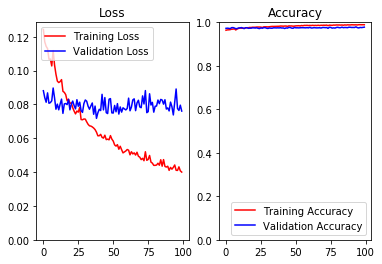

In [27]:
# Plot graphs of the loss/accuracy against epochs
loss_plot = plt.subplot(1,2,1)
loss_plot.set_title('Loss')
loss_plot.plot(training_history['train_loss'], 'r', label='Training Loss')
loss_plot.plot(training_history['valid_loss'], 'b', label='Validation Loss')
axes = plt.gca()
axes.set_ylim(ymin=0)
loss_plot.legend(loc=2)

accuracy_plot = plt.subplot(1,2,2)
axes = plt.gca()
axes.set_ylim([0, 1])
accuracy_plot.set_title('Accuracy')
accuracy_plot.plot(training_history['train_accuracy'], 'r', label='Training Accuracy')
accuracy_plot.plot(training_history['valid_accuracy'], 'b', label='Validation Accuracy')
accuracy_plot.legend(loc=4)

In [28]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_loss, train_accuracy = evaluate(X_train_normalised, y_train)
    validation_loss, validation_accuracy = evaluate(X_valid_normalised, y_valid)
    print("Train Accuracy = {:.3f}".format(train_accuracy))
    print("Valid Accuracy = {:.3f}".format(validation_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Train Accuracy = 0.989
Valid Accuracy = 0.978


### Evaluate model (once)

In [29]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    _, test_accuracy = evaluate(X_test_normalised, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.949


---

## Step 3: Test a Model on New Images

### Load and Output the Images

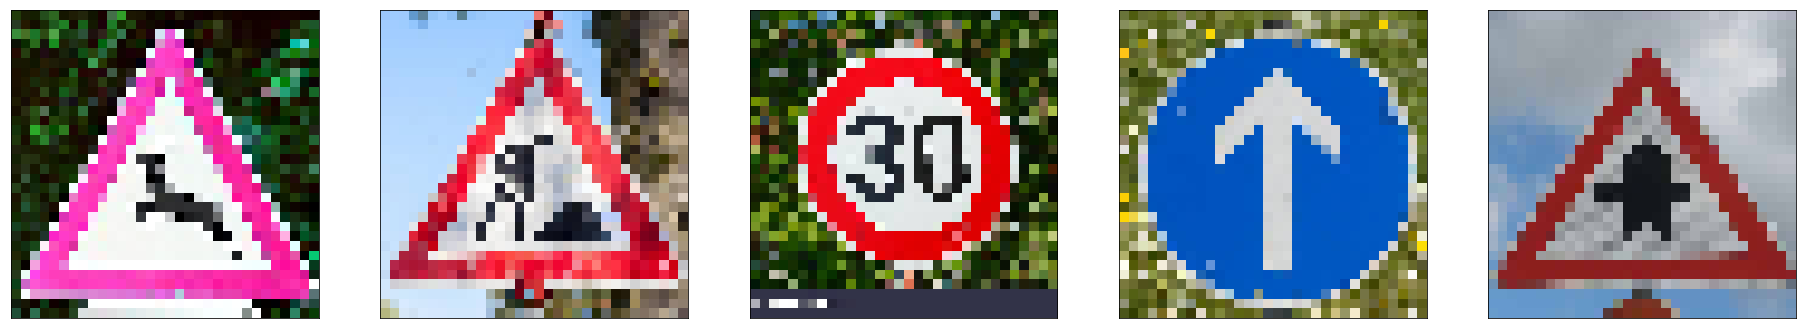

In [36]:
# Load
img_sources = [
    'wild_animals.jpg',
    'roadworks.jpg',
    'speed_limit_30.jpg',
    'ahead_only.jpg',
    'right_of_way.jpg'
]
y_new = [31, 25, 1, 35, 11]

# Manually label location of sign (x1, y1, x2, y2)
bounding_boxes = [
    (250, 27, 430, 207),
    (282, 0, 1112, 830),
    (172, 0, 1128, 956),
    (434, 33, 866, 465),
    (180, 0, 930, 750)
]

# Read in and convert to RGB
imgs = [cv2.imread('./GermanSigns/' + src) for src in img_sources]
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]

# Convert to correct dimensions (pad when necessary)
imgs = [img[bb[1]:bb[3], bb[0]:bb[2]] for img, bb in zip(imgs, bounding_boxes)]
imgs = [cv2.resize(img, (32,32), interpolation=cv2.INTER_CUBIC) for img in imgs]

# Plot
fig, axes = plt.subplots(1, 5, figsize=(32,32))
for ax, img in zip(axes, imgs):
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Label
X_new = np.array(imgs)

### Predict the Sign Type for Each Image

In [37]:
# Preprocess
X_new_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_new])
X_new_gray = X_new_gray[:,:,:,None]
X_new = np.concatenate((X_new, X_new_gray), axis=3)

equalizeHist(X_new)
X_new = X_new / 255. - 0.5

### Analyze Performance

In [40]:
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('.'))

    _, test_accuracy = evaluate(X_new, y_new)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.600


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [41]:
with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    predictions = sess.run(label_predictions,
                  feed_dict={x: X_new, y: y_new})
    top5_pred, idxs = sess.run(tf.nn.top_k(predictions, k=5))

    for i, top5, top5_prob in zip(y_new, idxs, top5_pred):
        print('---')
        print(signnames[i])
        for idx, p in zip(top5, top5_prob):
            print(p, '  ', signnames[idx])

INFO:tensorflow:Restoring parameters from ./lenet
---
Wild animals crossing
0.995314    Wild animals crossing
0.0039234    Double curve
0.000667547    Bicycles crossing
8.92286e-05    Road work
4.63612e-06    Road narrows on the right
---
Road work
0.960434    Bicycles crossing
0.0305923    Road work
0.00845695    Beware of ice/snow
0.00023013    Road narrows on the right
0.000171552    Wild animals crossing
---
Speed limit (30km/h)
0.999071    Speed limit (30km/h)
0.000929266    Speed limit (20km/h)
4.44314e-08    End of speed limit (80km/h)
2.6059e-08    Speed limit (80km/h)
4.66619e-09    Speed limit (100km/h)
---
Ahead only
1.0    Ahead only
3.39009e-11    Turn left ahead
8.47816e-21    Turn right ahead
1.44101e-25    Go straight or right
2.07674e-28    Go straight or left
---
Right-of-way at the next intersection
0.992573    Beware of ice/snow
0.00742608    Bicycles crossing
5.06889e-07    Double curve
3.69471e-07    Wild animals crossing
2.76172e-07    Right-of-way at the next in

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [50]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
#     activation = tf_activation.eval(session=sess, feed_dict={x : image_input})

    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess,tf.train.latest_checkpoint('.'))
    activation = sess.run(tf_activation,feed_dict={x:image_input})

    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet
INFO:tensorflow:Restoring parameters from ./lenet


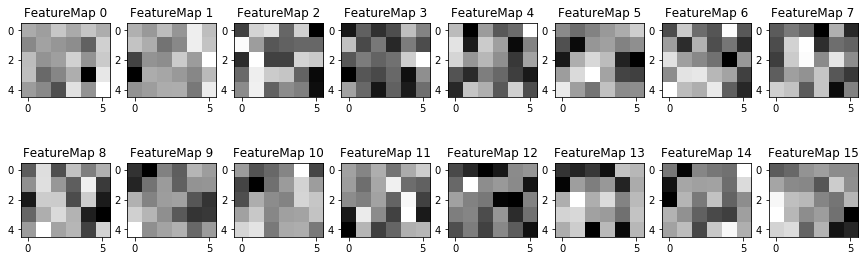

In [53]:
# Note - using the already preprocessd image
for v in tf.global_variables():
    outputFeatureMap(X_train_normalised[4:5], var)

# var = [v for v in tf.global_variables() if v.name == 'Variable_1:0'][0]
# outputFeatureMap(X_train_normalised[4:5], var)
# outputFeatureMap(X_train_normalised[5], conv2)
# outputFeatureMap(X_train_normalised[5], fc1)